In [1]:
from hicpap import paptools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)
np.set_printoptions(threshold=10)
# np.random.seed(3)

length = 20, (0.5, 1) <br>

* 正在寫 hand on examples, 
  * 透過 GC-content flip track 的正負號。需要外部套件的 Support，沒有在自己的套件撰寫功能。
  * 提供 track & Pearson 的視覺化範例。
討論：
1. 是否可以直接根據 reference genome 的 fastq GC-content flip
2. 如果 reference genome 都是相同的，測試的效益是不是不太夠。Eg, Rao 2014 gm12878, imr90, k562......的 chrom1 互相比較。

發現：
1. 如果 Pearson 的圖沒有規律，那就不用看 PC1 了，正確率會很低。
2. 因為 hic 的 Pearson 是對稱的，所以解釋變異量會很高，如果是沒有規律的圖解釋變異量會很低。

In [2]:
def generate_pearson(variance_threshold_L = 0, variance_threshold_U = 1):
    """
        Generates a random nxn symmetric matrix with positive values and
        the first PC explaining at least L% and at most U% of the variance.
    """
    length = 500

    while True:
        # Create a nxn array with random positive values
        matrix_np = np.abs(np.random.randn(length, length) * 10)  # Use absolute values for positive entries
        # Make the array symmetric
        matrix_np = matrix_np + matrix_np.T

        pearson_np = np.corrcoef(matrix_np)
        # Subtract the mean of each row to center the data
        pearson_np = pearson_np - pearson_np.mean(axis=1, keepdims=True)

        # SVD 
        n = len(pearson_np[0])
        y = pearson_np.T / np.sqrt(n)
        U, S, Vh = np.linalg.svd(y, full_matrices=True)
        eigenvalues = S * S
        EV1_explained_variance = eigenvalues[0] / np.sum(eigenvalues) 

        # Check if the first PC explains at least the desired variance
        if EV1_explained_variance >= variance_threshold_L and EV1_explained_variance < variance_threshold_U:
            return pearson_np 

# Generate a matrix that meets the conditions
pearson_np = generate_pearson()

print(np.mean(pearson_np[0]))
print(np.mean(pearson_np[1]))
print(np.mean(pearson_np[2]))

4.440892098500626e-19
1.5543122344752192e-18
-6.661338147750939e-19


my pc1

In [3]:
Vh, explained_variances, total_entry_num, valid_entry_num = paptools.pca_on_pearson(pearson_np=pearson_np)
pc1_np = Vh[0]
print(explained_variances)
print(np.sum(explained_variances))

[0.01631 0.01476 0.01427 ... 0.      0.      0.     ]
1.0


sklearn

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(pearson_np[0]))
pca.fit(pearson_np)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))


[0.01632 0.01477 0.01428 ... 0.      0.      0.     ]
1.000000000000001


In [5]:
approx_np = paptools.create_approx(pearson_np=pearson_np)
print(pc1_np)
print(approx_np)

[ 0.10202  0.00285  0.04106 ... -0.02226 -0.03879 -0.05259]
[-0.00044  0.0001   0.00021 ...  0.00027 -0.00019  0.00001]


In [6]:
correctness_info = paptools.calc_correctness(pc1_np=pc1_np, approx_np=approx_np)
display(correctness_info)

{'total_entry_num': 500,
 'valid_entry_num': 500,
 'correct_num': 260,
 'correct_rate': 0.52}

[]

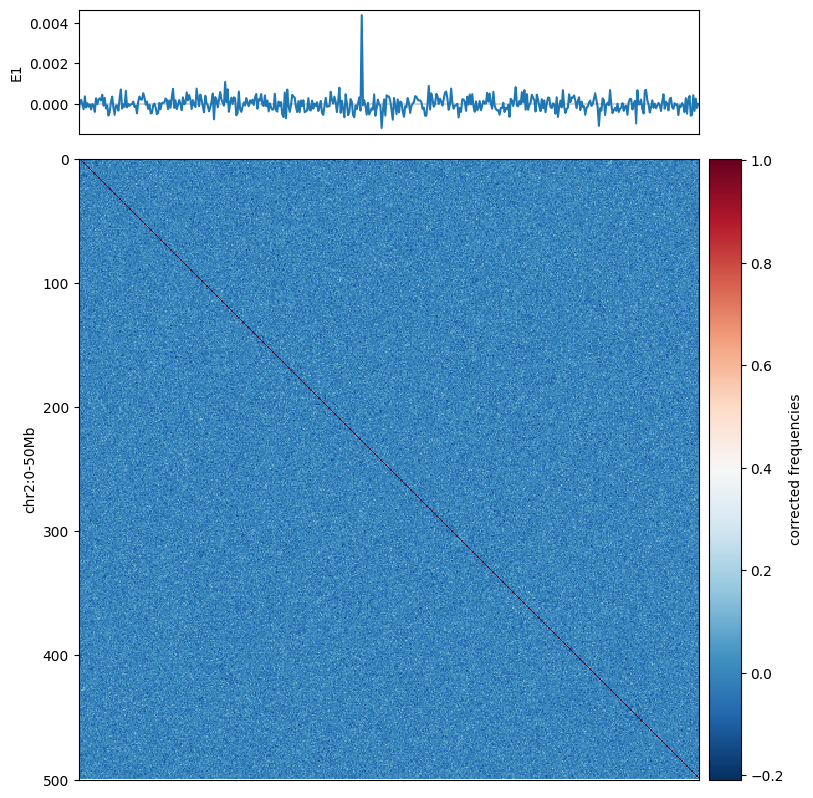

In [7]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)
plt.axis([0,len(approx_np),len(approx_np),0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
ax1.plot([0,len(approx_np)],[0,0],'k',lw=0.25)
ax1.plot(approx_np, label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([])

In [8]:
plt.close()

[]

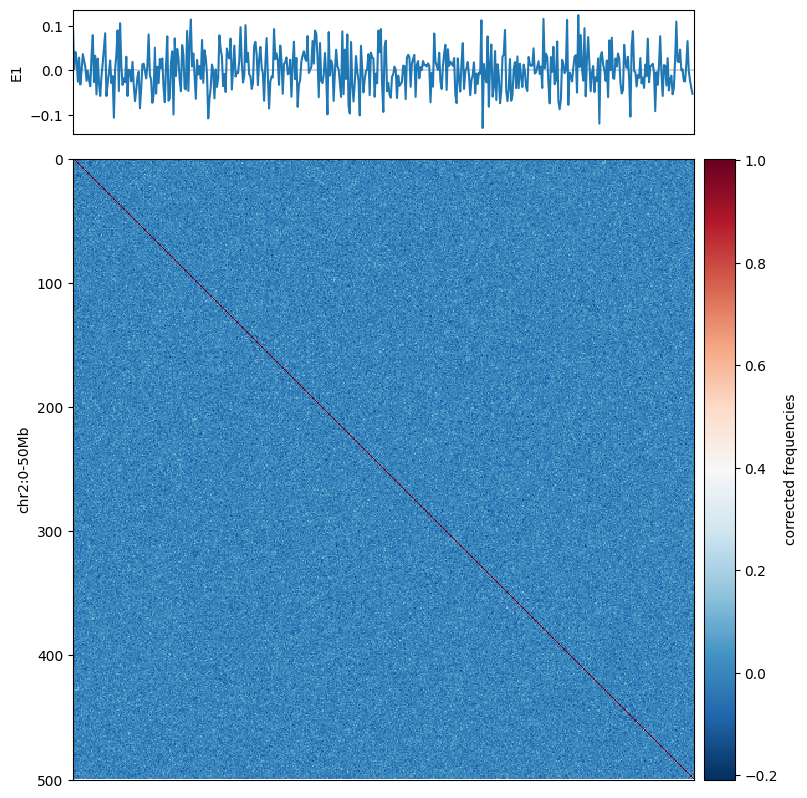

In [9]:
f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)
plt.axis([0,len(pc1_np),len(pc1_np),0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
ax1.plot([0,len(pc1_np)],[0,0],'k',lw=0.25)
ax1.plot(pc1_np, label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([])

test chrom1

In [10]:
import seaborn as sns
path = "/media/jordan990301/Samsung_T5/HiC_Datasets/data_for_hicpap/data_store/data/rao_2014/juicer_outputs"

Text(0.5, 1.0, 'title')

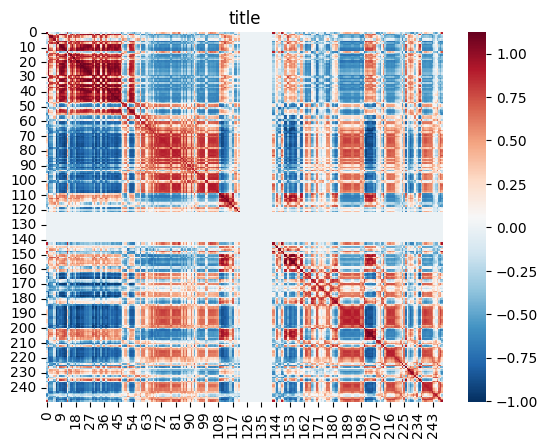

In [11]:
pearson_np = paptools.read_pearson(f"{path}/gm12878/1000000/pearsons/pearson_chr1.txt")

ax = plt.axes()
sns.heatmap(pearson_np, ax=ax, cmap="RdBu_r")
ax.set_title(f'title')

Text(0.5, 1.0, 'title')

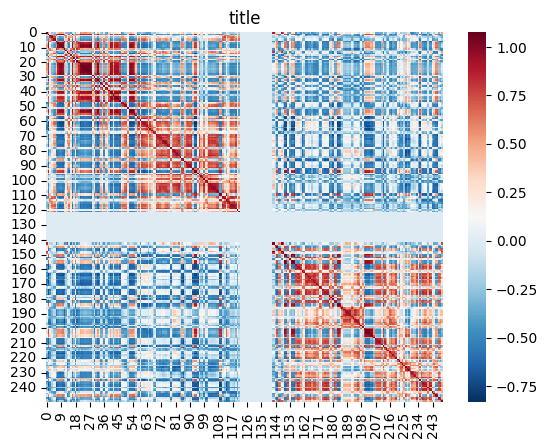

In [12]:
pearson_np = paptools.read_pearson(f"{path}/imr90/1000000/pearsons/pearson_chr1.txt")

ax = plt.axes()
sns.heatmap(pearson_np, ax=ax, cmap="RdBu_r")
ax.set_title(f'title')

Text(0.5, 1.0, 'title')

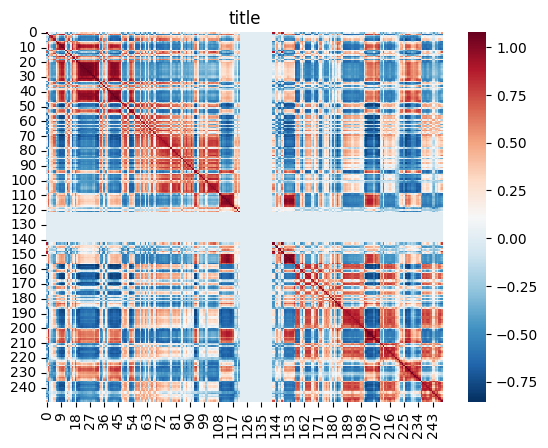

In [13]:
pearson_np = paptools.read_pearson(f"{path}/hmec/1000000/pearsons/pearson_chr1.txt")

ax = plt.axes()
sns.heatmap(pearson_np, ax=ax, cmap="RdBu_r")
ax.set_title(f'title')

test chrom2

Text(0.5, 1.0, 'title')

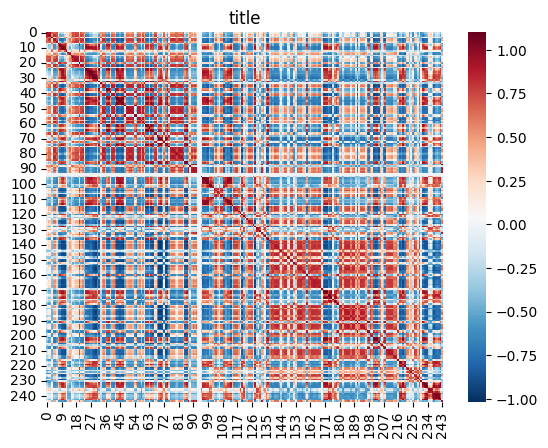

In [14]:
pearson_np = paptools.read_pearson(f"{path}/gm12878/1000000/pearsons/pearson_chr2.txt")

ax = plt.axes()
sns.heatmap(pearson_np, ax=ax, cmap="RdBu_r")
ax.set_title(f'title')

Text(0.5, 1.0, 'title')

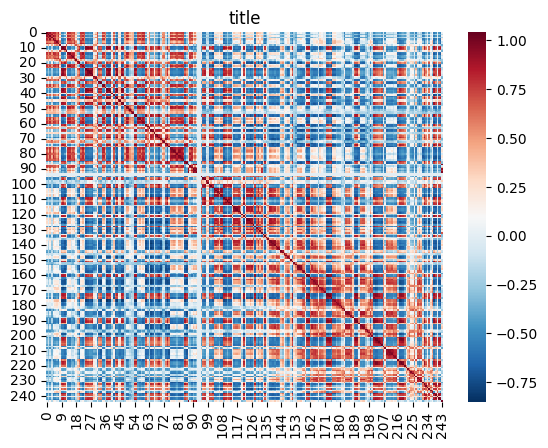

In [15]:
pearson_np = paptools.read_pearson(f"{path}/imr90/1000000/pearsons/pearson_chr2.txt")

ax = plt.axes()
sns.heatmap(pearson_np, ax=ax, cmap="RdBu_r")
ax.set_title(f'title')

Text(0.5, 1.0, 'title')

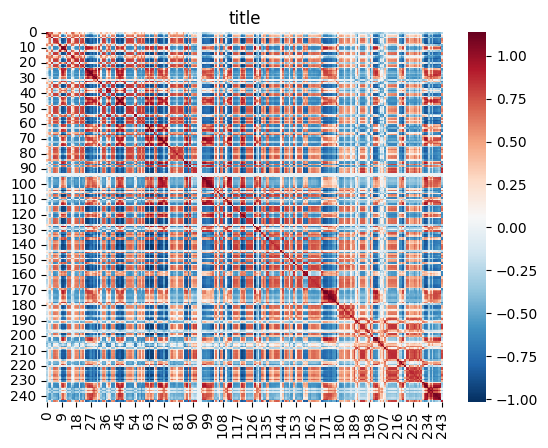

In [16]:
pearson_np = paptools.read_pearson(f"{path}/k562/1000000/pearsons/pearson_chr2.txt")

ax = plt.axes()
sns.heatmap(pearson_np, ax=ax, cmap="RdBu_r")
ax.set_title(f'title')